In [1]:
colab_run = False
if colab_run:
    !pip -q install git+https://github.com/adalca/pystrum.git
    !pip -q install git+https://github.com/adalca/neurite.git
    !pip -q install git+https://github.com/voxelmorph/voxelmorph.git

In [2]:
model_loc = 'Models/'
csv_loc = 'CSV/'

In [3]:
# imports
import os, sys

# third party imports
import numpy as np
import tqdm
import pandas as pd
import tensorflow as tf
import voxelmorph as vxm
import neurite as ne
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback

2023-08-17 23:06:26.683658: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-17 23:06:27.440197: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:

## As per the tensorflow error #60309, advice by tgoMota on github, making verbose = 2

verbose = 2

In [5]:
# Conform test data.
def conform(x, in_shape = (256,) * 2):
    '''Resize and normalize image.'''
    x = np.float32(x)
    x = ne.utils.minmax_norm(x)
    x = ne.utils.zoom(x, zoom_factor=[o / i for o, i in zip(in_shape, x.shape)])
    return np.expand_dims(x, axis=(0, -1))


In [6]:
def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

In [7]:
def vxm_data_generator_hybrid(x_data_real, x_data_synth, label_to_image, alpha_real=0.9, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """    
    # preliminary sizing
    vol_shape = x_data_real.shape[1:] # extract data shape
    ndims = len(vol_shape)

    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])

    batch_size_real = int(alpha_real*batch_size)
    batch_size_synth = batch_size - batch_size_real


    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1_real = np.random.randint(0, x_data_real.shape[0], size=batch_size_real)
        moving_images_real = x_data_real[idx1_real, ..., np.newaxis]
        idx2_real = np.random.randint(0, x_data_real.shape[0], size=batch_size_real)
        fixed_images_real = x_data_real[idx2_real, ..., np.newaxis]



        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1_synth = np.random.randint(0, x_data_synth.shape[0], size=batch_size_synth)
        moving_images_synth = x_data_synth[idx1_synth, ..., np.newaxis]
        idx2_synth = np.random.randint(0, x_data_synth.shape[0], size=batch_size_synth)
        fixed_images_synth = x_data_synth[idx2_synth, ..., np.newaxis]

        moving_images = np.concatenate([moving_images_real, label_to_image(moving_images_synth)], axis=0)
        fixed_images = np.concatenate([fixed_images_real, label_to_image(fixed_images_synth)], axis=0)

        inputs = [moving_images, fixed_images]

        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

In [8]:
def vxm_data_generator_real(x_data, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

def vxm_data_generator_synth(x_data, label_to_image, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = label_to_image(x_data[idx1, ..., np.newaxis])
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = label_to_image(x_data[idx2, ..., np.newaxis])
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

In [9]:
class SynthLabels():
    def __init__(self, num_label=16, num_maps=250):
        # Input shapes.
        self.in_shape = (256,) * 2
        self.num_dim = len(self.in_shape)
        self.num_label = num_label
        self.num_maps = num_maps
        gen_arg = dict(
            in_shape=self.in_shape,
            in_label_list=np.arange(16),
            warp_std=3,
            warp_res=(8, 16, 32),
        )
        self.gen_model = ne.models.labels_to_image(**gen_arg, id=1)

    def label_maps(self):
        # Shape generation.
        self.label_maps = []
        self.label_maps = np.zeros((self.num_maps, 256, 256))
        for i in tqdm.tqdm(range(self.num_maps)):
            # Draw image and warp.
            im = ne.utils.augment.draw_perlin(
                out_shape=(*self.in_shape, self.num_label),
                scales=(32, 64), max_std=1,
            )
            warp = ne.utils.augment.draw_perlin(
                out_shape=(*self.in_shape, self.num_label, self.num_dim),
                scales=(16, 32, 64), max_std=16,
            )
            # Transform and create label map.
            im = vxm.utils.transform(im, warp)
            lab = tf.argmax(im, axis=-1)
            self.label_maps[i] = np.uint8(lab)
        return self.label_maps
    
    
    def label_to_image(self, sample):
        return self.gen_model.predict(sample, verbose=verbose)[0]

2023-08-17 23:06:49.209229: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-17 23:06:49.237004: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-17 23:06:49.237215: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

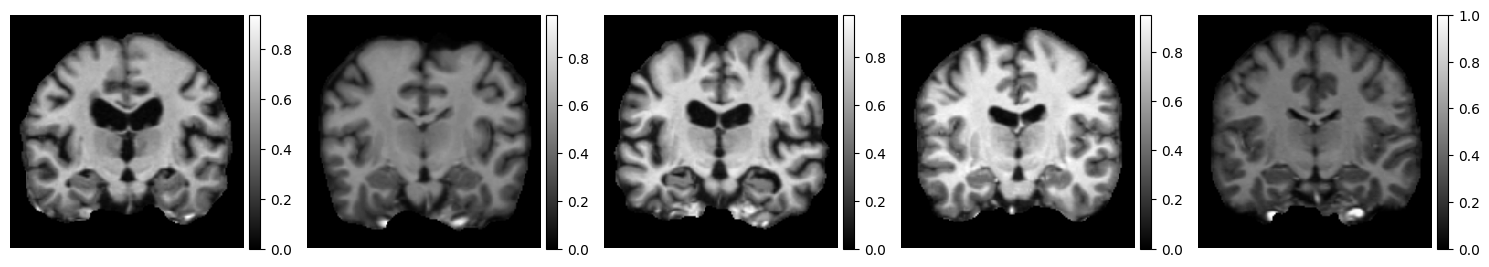

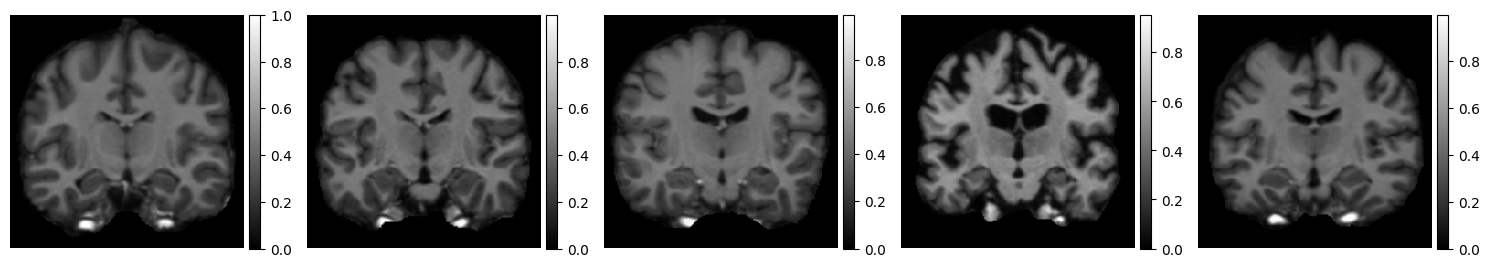

In [10]:
#Loading the dataset
images = ne.py.data.load_dataset('2D-OASIS-TUTORIAL')
conformed_images = [conform(img) for img in images]
#label_maps_real = [(img*15).astype('int').reshape(256, 256) for img in conformed_images]
label_maps_real = [img.reshape(256, 256) for img in conformed_images]


# Visualizing the dataset.
num_row = 2
per_row = 5
for i in range(0, num_row * per_row, per_row):
    ne.plot.slices(label_maps_real[i:i + per_row], cmaps=['gray'], do_colorbars=True)

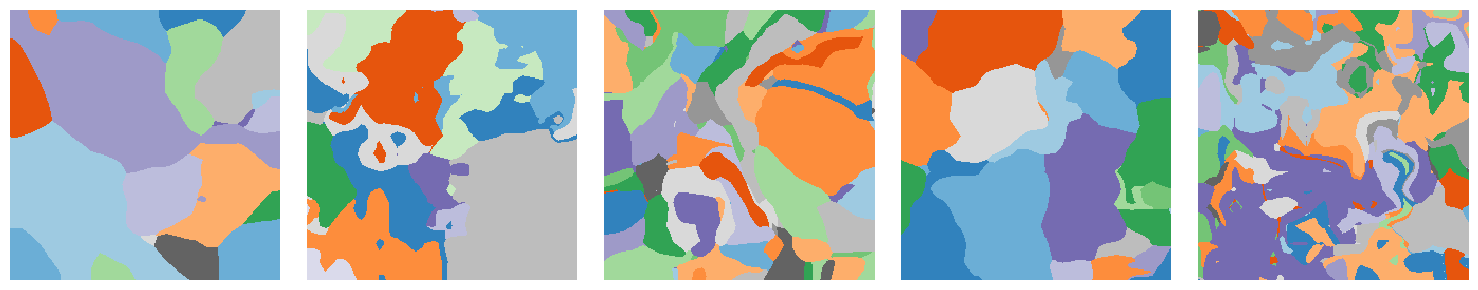

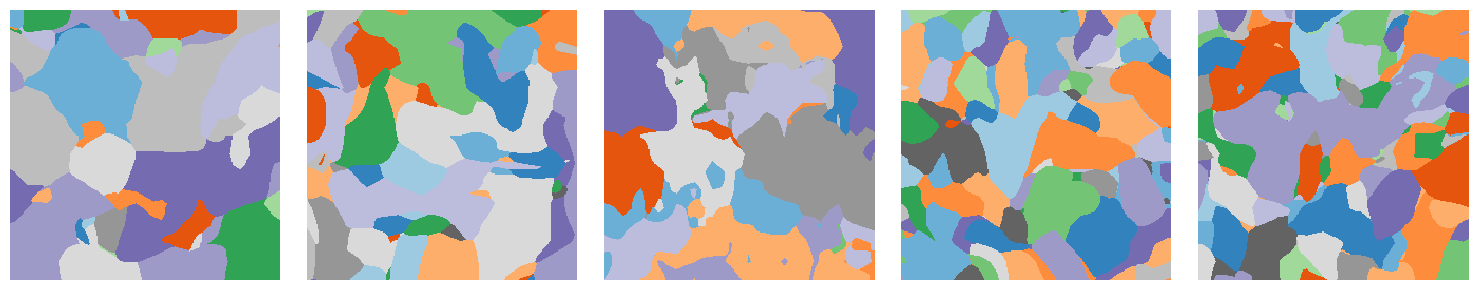

In [11]:
if os.path.exists('Synthetic_data.npy'):
    SynthIm = SynthLabels()
    label_maps_synth = np.load('Synthetic_data.npy')
    SynthIm.label_maps = label_maps_synth
else:
    SynthIm = SynthLabels()
    label_maps_synth = SynthIm.label_maps()
    np.save('Synthetic_data.npy', label_maps_synth)

# Visualize shapes.
num_row = 2
per_row = 5
for i in range(0, num_row * per_row, per_row):
    ne.plot.slices(list(label_maps_synth[i:i + per_row]), cmaps=['tab20c'])

In [12]:
class VxmTest():
    def __init__(self, ndim = 2, unet_input_features = 2):
        self.ndim = ndim
        self.unet_input_features = unet_input_features
    #CNN model
        # configure unet input shape (concatenation of moving and fixed images)
        self.vol_shape = real_train.shape[1:]
        # configure unet features 
        self.nb_features = [
            [32, 32, 32, 32],         # encoder features
            [32, 32, 32, 32, 32, 16]  # decoder features
        ]
        
        
    def CNNvxm(self, train_gen=None, val_generator=None):
        self.vxm_model = vxm.networks.VxmDense(self.vol_shape, nb_unet_features=None, int_steps=0)
        self.losses = ['mse', vxm.losses.Grad('l2').loss]
        self.loss_weights = [1, 0.01]
        self.vxm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=self.losses, loss_weights=self.loss_weights)
        

        self.train_generator = train_gen
        self.val_generator = val_generator

        self.in_sample, self.out_sample = next(self.train_generator)
        def Visual():
            # visualize
            images = [img[0, :, :, 0] for img in self.in_sample + self.out_sample]
            titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
            ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);
        Visual()
        
    def train(self, total_epo, steps_per_epoch=100):
        self.hist = self.vxm_model.fit(self.train_generator, epochs=total_epo,
                                       steps_per_epoch=100, verbose=verbose,
                                       callbacks=[TqdmCallback(verbose=verbose)],
                                       validation_data=self.val_generator,
                                       validation_steps = 100);
        plot_history(self.hist)
        
    def RegPred(self, val_input):
        self.val_pred = self.vxm_model.predict(val_input)
        #visualise
        def Visual():
            images = [img[0, :, :, 0] for img in val_input + self.val_pred] 
            titles = ['moving', 'fixed', 'moved', 'flow']
            ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);
        Visual()
        return self.val_pred

In [13]:
#Fixing data + spliting

#conversion of labels in range of [0,1]
label_maps_real = np.array(label_maps_real)
label_maps_synth = np.array(label_maps_synth)
#label_maps_real = label_maps_real.astype('float')/15
#label_maps_synth = label_maps_synth.astype('float')/15
#label_maps_hy = np.zeros((250, 256, 256))
#label_maps_hy[::2] = [i for i in label_maps_real[:125, ...]]
#label_maps_hy[1::2] = [i for i in label_maps_synth[:125, ...]]
#label_maps_hy = np.array(label_maps_hy)

#data split 
Data_split_train = 250
real_train = label_maps_real[:250, ...]
# few_shot_train = label_maps_real[:50, ...]
test_val_no = 82
real_val = label_maps_real[250:332, ...]
real_test = label_maps_real[-82:, ...]

In [14]:
# if colab_run:
#     train_no = 100
#     batch_size = 8
# else:
#     train_no = 2000
#     batch_size = 32

In [15]:
train_no = 2
# no_of_rounds = 2
batch_size = 5
alpha_real = 0.9

In [16]:
# create the few shot data generator
# few_generator = vxm_data_generator_real(real_train, batch_size = 8)
# few_input, _ = next(few_generator)

# create the training data generator
train_generator = vxm_data_generator_real(real_train, batch_size = batch_size)
train_input, _ = next(train_generator)

# create the validation data generator
val_generator = vxm_data_generator_real(real_val, batch_size = batch_size)
val_input, _ = next(val_generator)

# create synthetic data generator
synth_generator = vxm_data_generator_synth(label_maps_synth, SynthIm.label_to_image, batch_size=batch_size)
synth_input, _ = next(synth_generator)

#example of the hybrid data generator
hybrid_generator = vxm_data_generator_hybrid(real_train, label_maps_synth, SynthIm.label_to_image, alpha_real=alpha_real, batch_size=batch_size)
hybrid_input, _ = next(hybrid_generator)

2023-08-17 23:07:20.178365: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


1/1 - 2s - 2s/epoch - 2s/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 73ms/epoch - 73ms/step
1/1 - 0s - 23ms/epoch - 23ms/step


In [17]:
def plot_csv(filename):
    df = pd.read_csv(filename)
    nu = df.to_numpy()
    fh = nu.size
    plt.figure()
    plt.plot(range(1,nu.size+1), nu, '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

1/1 - 0s - 52ms/epoch - 52ms/step
1/1 - 0s - 56ms/epoch - 56ms/step


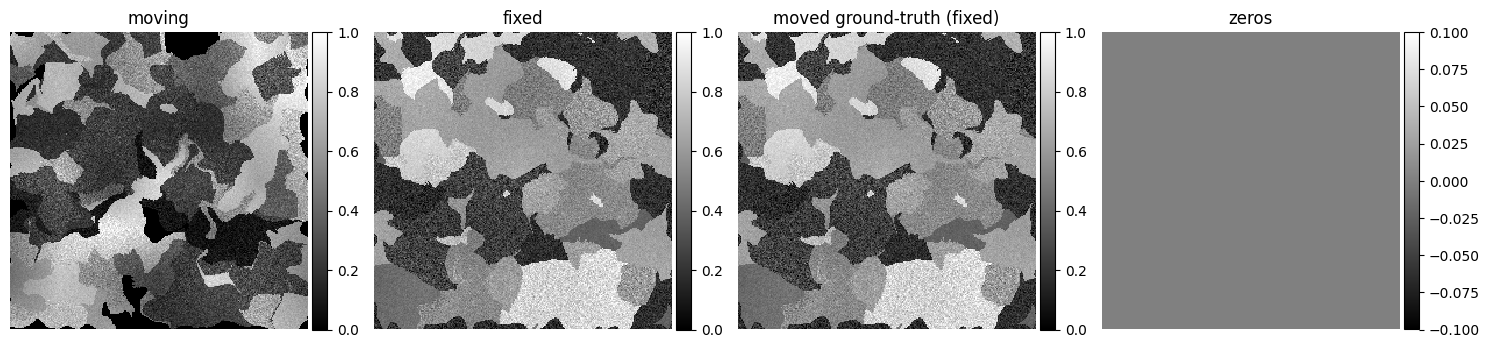

0epoch [00:00, ?epoch/s]

1/1 - 0s - 61ms/epoch - 61ms/step
1/1 - 0s - 42ms/epoch - 42ms/step


  0%|          | 0.00/100 [00:00<?, ?batch/s]

Epoch 1/2
1/1 - 0s - 133ms/epoch - 133ms/step
1/1 - 0s - 94ms/epoch - 94ms/step
1/1 - 0s - 122ms/epoch - 122ms/step
1/1 - 0s - 402ms/epoch - 402ms/step


2023-08-17 23:07:26.964235: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6695e46e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-17 23:07:26.964265: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2023-08-17 23:07:26.968692: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-17 23:07:27.101400: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 - 0s - 82ms/epoch - 82ms/step
1/1 - 0s - 37ms/epoch - 37ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 37ms/epoch - 37ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 36m

  0%|          | 0.00/100 [00:00<?, ?batch/s]

Epoch 2/2
1/1 - 0s - 149ms/epoch - 149ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 39ms/epoch - 39ms/step
1/1 - 0s - 40ms/epoch - 40ms/step
1/1 - 0s - 42ms/epoch - 42ms/step
1/1 - 0s - 40ms/epoch - 40ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 37ms/epoch - 37ms/step
1/1 - 0s - 49ms/epoch - 49ms/step
1/1 - 0s - 39ms/epoch - 39ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 37ms/epoch - 37ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 40ms/epoch - 40ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 37ms/epoch - 37ms/step
1/1 - 0s - 37ms/epoch - 37ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 37ms/epoch - 37ms/step
1/1 - 0s - 37ms/epoch - 37ms/step
1/1 - 0s - 40ms/epoch - 40ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/

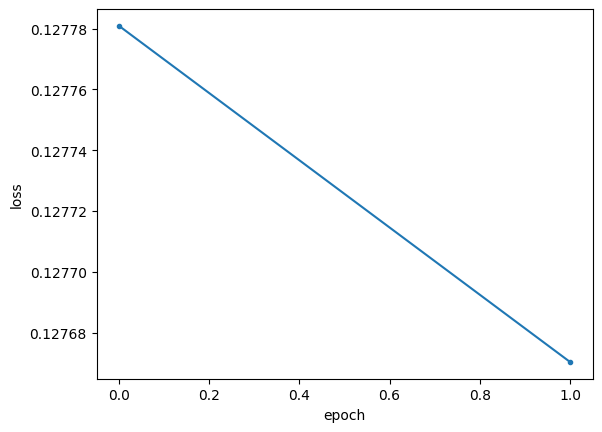

In [18]:
Synth = VxmTest()
Synth.CNNvxm(train_gen=synth_generator, val_generator=val_generator)
Synth.train(total_epo=train_no)
Synth.vxm_model.save_weights(model_loc+'Synth_pure.h5')
b = Synth.hist.history['loss']
df = pd.DataFrame(b )
df.to_csv(csv_loc+'Synth_pure_loss.csv', index=False, header=False)
# for i in range(no_of_rounds-1):
#     Synth.vxm_model.load_weights(model_loc+'Synth_pure.h5')
#     Synth.train(total_epo=train_no)
#     Synth.vxm_model.save_weights(model_loc+'Synth_pure.h5')
#     b = Synth.hist.history['loss']
#     df = pd.DataFrame(b)
#     df.to_csv(csv_loc+'Synth_pure_loss.csv', index=False, mode='a', header=False)

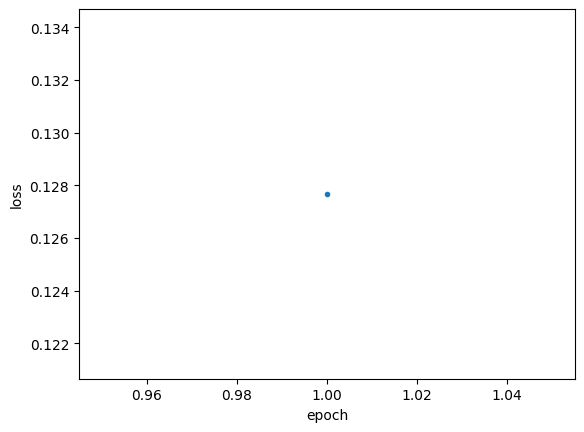

In [19]:
plot_csv(csv_loc + 'Synth_pure_loss.csv')

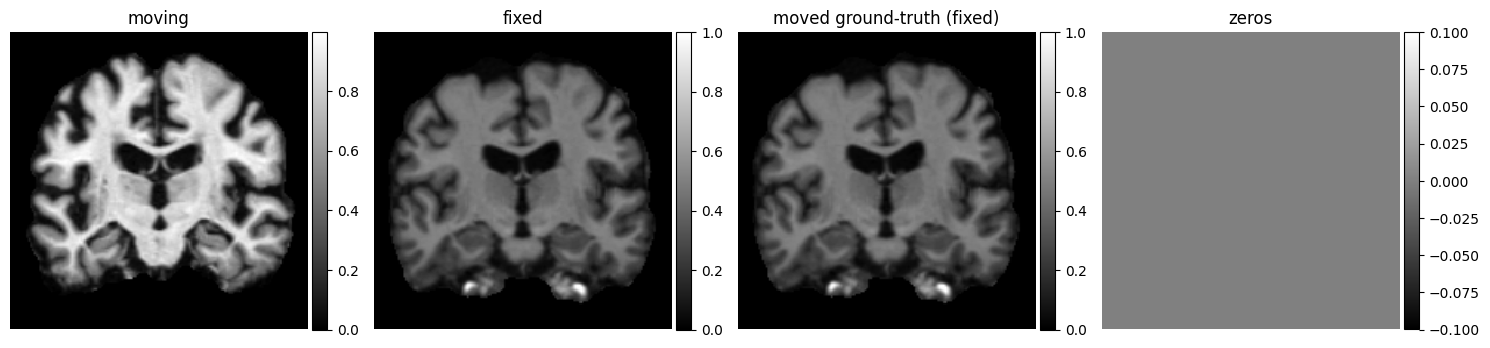

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/100 [00:00<?, ?batch/s]

Epoch 1/2
100/100 - 14s - loss: 0.0285 - vxm_dense_transformer_loss: 0.0285 - vxm_dense_flow_loss: 3.3480e-04 - val_loss: 0.0279 - val_vxm_dense_transformer_loss: 0.0279 - val_vxm_dense_flow_loss: 0.0061 - 14s/epoch - 143ms/step


  0%|          | 0.00/100 [00:00<?, ?batch/s]

Epoch 2/2
100/100 - 10s - loss: 0.0219 - vxm_dense_transformer_loss: 0.0213 - vxm_dense_flow_loss: 0.0672 - val_loss: 0.0217 - val_vxm_dense_transformer_loss: 0.0205 - val_vxm_dense_flow_loss: 0.1178 - 10s/epoch - 96ms/step


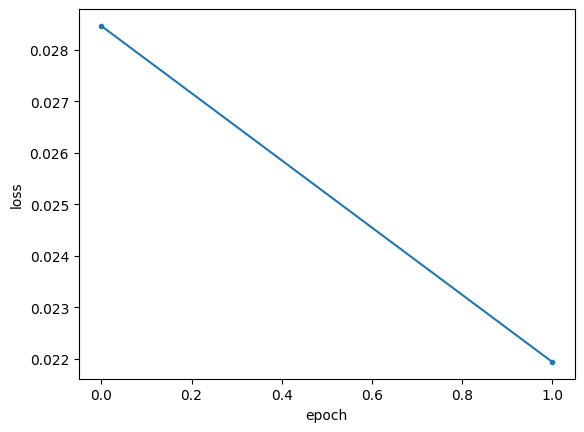

In [20]:
Real = VxmTest()
Real.CNNvxm(train_gen=train_generator, val_generator=val_generator)
Real.train(total_epo=train_no)
Real.vxm_model.save_weights(model_loc+'Real_100steps.h5')
b = Real.hist.history['loss']
df = pd.DataFrame(b)
df.to_csv(csv_loc+'Real_loss_100steps.csv', index=False, header=False)
# for i in range(no_of_rounds-1):
#     Real.vxm_model.load_weights(model_loc+'Real_100steps.h5')
#     Real.train(total_epo=train_no)
#     Real.vxm_model.save_weights(model_loc+'Real_100steps.h5')
#     b = Real.hist.history['loss']
#     df = pd.DataFrame(b)
#     df.to_csv(csv_loc+'Real_loss_100steps.csv', index=False, mode='a', header=False)

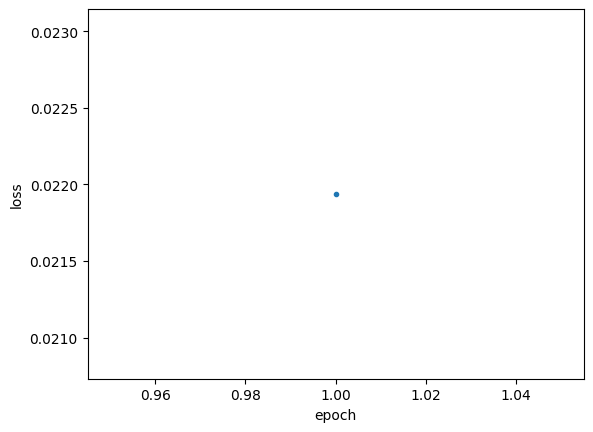

In [21]:
plot_csv(csv_loc+'Real_loss_100steps.csv')

In [22]:
for i in range(5, 15, 5):
    exec(f'few_shot_train_{i} = label_maps_real[:i, ...]')
# create the few shot data generator
    exec(f'few_generator_{i} = vxm_data_generator_hybrid(few_shot_train_{i}, label_maps_synth, SynthIm.label_to_image, alpha_real=alpha_real, batch_size = batch_size)')
    exec(f'train_generator_{i} = vxm_data_generator_real(few_shot_train_{i}, batch_size = batch_size)')
    exec(f'few_input_{i}, _ = next(few_generator_{i})')
    exec(f'train_input_{i}, _ = next(train_generator_{i})')

1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 21ms/epoch - 21ms/step


In [23]:
goblin = '.h5'
goblin_csv = '.csv'
name = 'Hybrid_'
led = 'loss'
mode_csv = 'a'
name_loss = 'Hybrid_loss_pure'

1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 51ms/epoch - 51ms/step


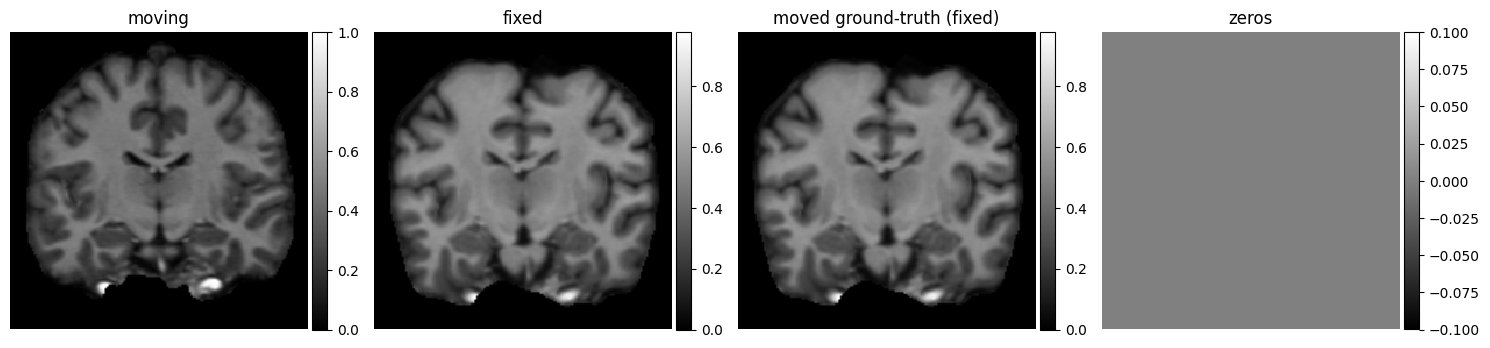

0epoch [00:00, ?epoch/s]

1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 26ms/epoch - 26ms/step


  0%|          | 0.00/100 [00:00<?, ?batch/s]

Epoch 1/2
1/1 - 0s - 46ms/epoch - 46ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 29ms/epoch - 29ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 74ms/epoch - 74ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 44ms/epoch - 44ms/step
1/1 - 0s - 40ms/epoch - 40ms/step
1/1 - 0s - 45ms/epoch - 45ms/step
1/1 - 0s - 36ms/epoch - 36ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 42ms/epoch - 42ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 44ms/epoch - 44ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 

  0%|          | 0.00/100 [00:00<?, ?batch/s]

Epoch 2/2
1/1 - 0s - 92ms/epoch - 92ms/step
1/1 - 0s - 41ms/epoch - 41ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 46ms/epoch - 46ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 29ms/epoch - 29ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 30ms/epoch - 30ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 48ms/epoch - 48ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 45ms/epoch - 45ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 

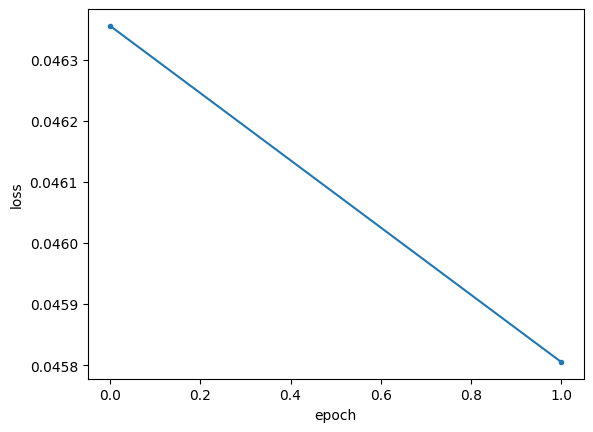

1/1 [==============================] - 0s 310ms/step


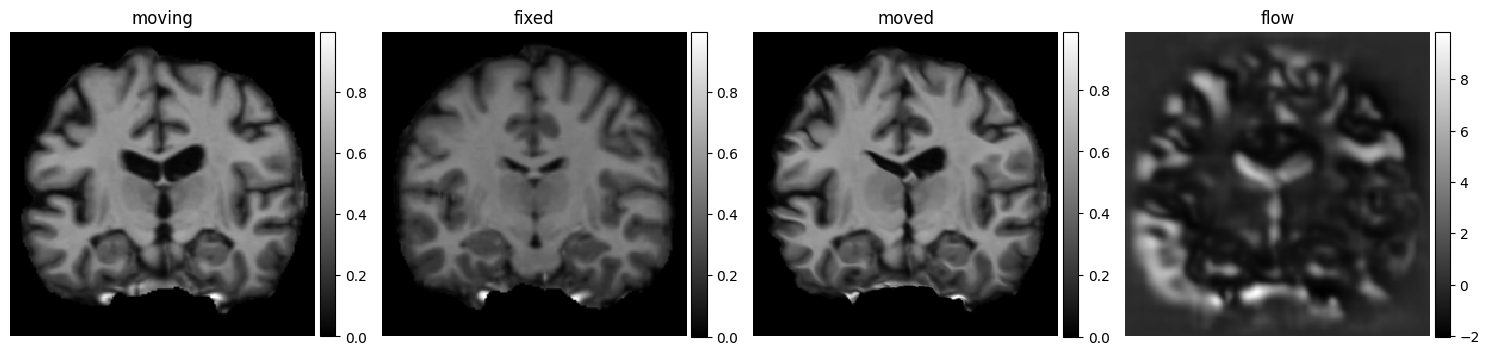

1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 23ms/epoch - 23ms/step


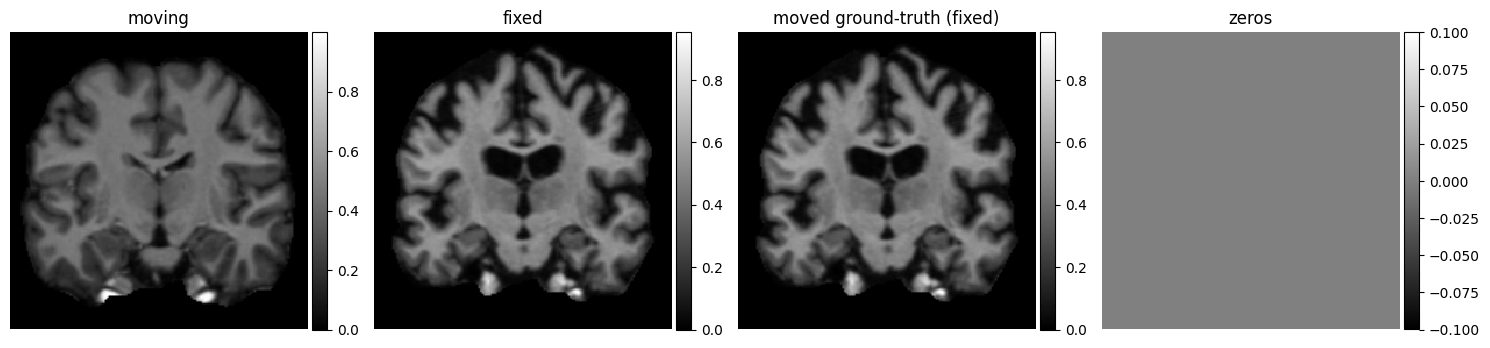

0epoch [00:00, ?epoch/s]

1/1 - 0s - 73ms/epoch - 73ms/step
1/1 - 0s - 39ms/epoch - 39ms/step


  0%|          | 0.00/100 [00:00<?, ?batch/s]

Epoch 1/2
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 30ms/epoch - 30ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 30ms/epoch - 30ms/step
1/1 - 0s - 122ms/epoch - 122ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 44ms/epoch - 44ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 30ms/epoch - 30ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 45ms/epoch - 45ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 45ms/epoch - 45ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 46ms/epoch - 46ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 46ms/epoch - 46ms/step
1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/

  0%|          | 0.00/100 [00:00<?, ?batch/s]

Epoch 2/2
1/1 - 0s - 97ms/epoch - 97ms/step
1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 46ms/epoch - 46ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 46ms/epoch - 46ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 50ms/epoch - 50ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 46ms/epoch - 46ms/step
1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 45ms/epoch - 45ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 

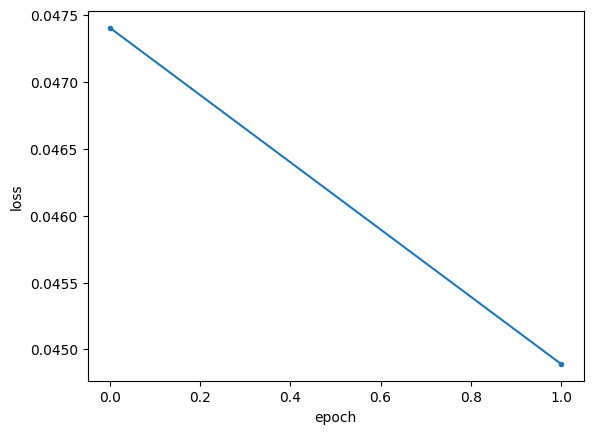

1/1 [==============================] - 0s 315ms/step


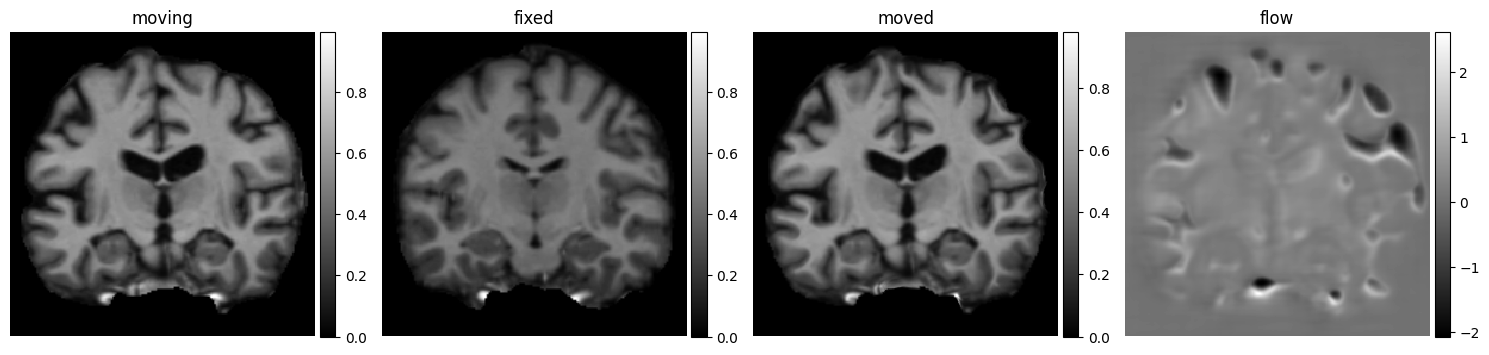

In [24]:
#Few shots training
for k in range(5, 15, 5):
    exec(f'Fshot_{k} = VxmTest()')
    exec(f'Fshot_{k}.CNNvxm(train_gen=few_generator_{k}, val_generator=val_generator)')
    exec(f'Fshot_{k}.train(total_epo = train_no)')
    exec(f'loc = model_loc+name+str({k})+goblin')
    exec(f'Fshot_{k}.vxm_model.save_weights(model_loc+name+str({k})+goblin)')
    exec(f'b = Fshot_{k}.hist.history[led]')
    exec(f'df = pd.DataFrame(b)')
    exec(f'loc = csv_loc+name_loss+str({k})+goblin_csv')
    exec(f'df.to_csv(loc, index=False, header=False)')
    # for i in range(no_of_rounds-1):
    #     exec(f'Fshot_{k}.vxm_model.load_weights(model_loc+name+str({k})+goblin)')
    #     exec(f'Fshot_{k}.train(total_epo = train_no)')
    #     exec(f'Fshot_{k}.vxm_model.save_weights(model_loc+name+str({k})+goblin)')
    #     exec(f'b = Fshot_{k}.hist.history[led]')
    #     exec(f'df = pd.DataFrame(b)')
    #     exec(f'loc = csv_loc+name_loss+str({k})+goblin_csv')
    #     exec(f'df.to_csv(loc, mode = mode_csv, index=False, header=False)')

    exec(f'fshot_{k} = Fshot_{k}.RegPred(val_input)[1]')

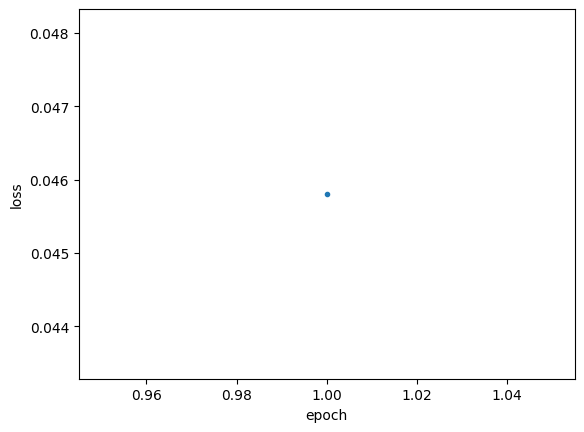

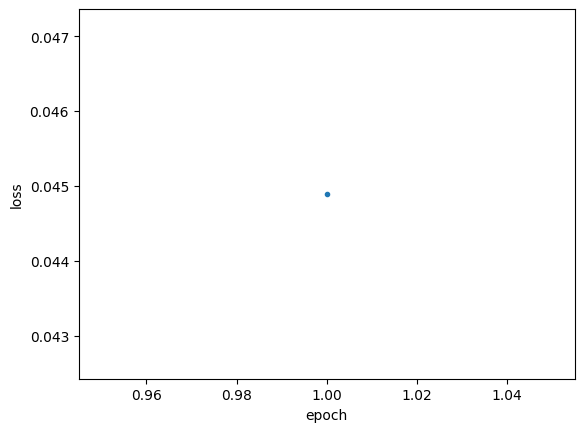

In [25]:
for k in range(5, 15, 5):
    exec(f'loc = csv_loc+name_loss+str({k})+goblin_csv')
    exec(f'plot_csv(loc)')

In [26]:
goblin = '.h5'
goblin_csv = '.csv'
name = 'Real_Fshot_'
mode_csv = 'a'
name_loss = 'Fshot_loss_pure'

1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 28ms/epoch - 28ms/step


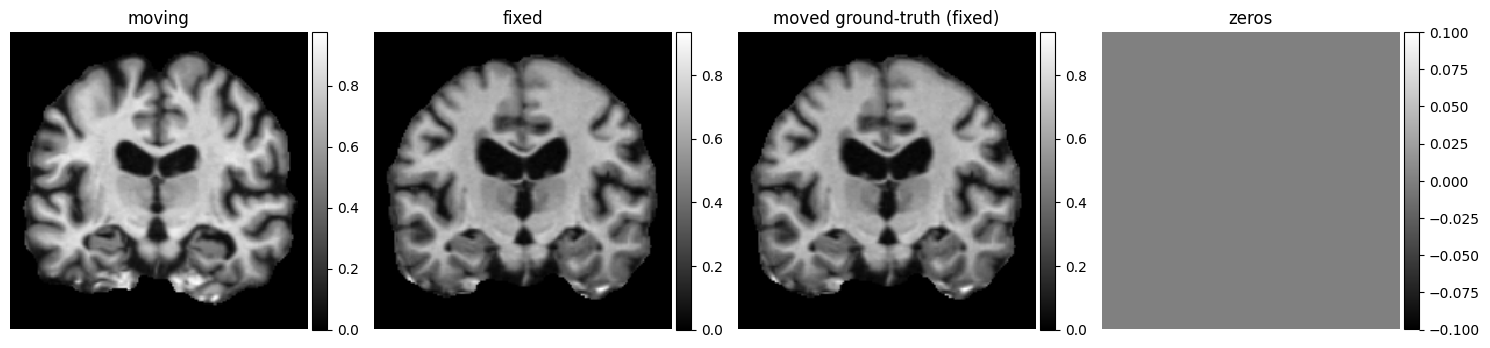

0epoch [00:00, ?epoch/s]

1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 23ms/epoch - 23ms/step


  0%|          | 0.00/100 [00:00<?, ?batch/s]

Epoch 1/2
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 125ms/epoch - 125ms/step
1/1 - 0s - 21ms/epoch - 21ms/step
1/1 - 0s - 39ms/epoch - 39ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 42ms/epoch - 42ms/step
1/1 - 0s - 21ms/epoch - 21ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 21ms/epoch - 21ms/step
1/1 - 0s - 44ms/epoch - 44ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 21ms/epoch - 21ms/step
1/1 - 0s - 46ms/epoch - 46ms/step
1/

  0%|          | 0.00/100 [00:00<?, ?batch/s]

Epoch 2/2
1/1 - 0s - 91ms/epoch - 91ms/step
1/1 - 0s - 21ms/epoch - 21ms/step
1/1 - 0s - 21ms/epoch - 21ms/step
1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 48ms/epoch - 48ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 43ms/epoch - 43ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 45ms/epoch - 45ms/step
1/1 - 0s - 21ms/epoch - 21ms/step
1/1 - 0s - 45ms/epoch - 45ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 21ms/epoch - 21ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 47ms/epoch - 47ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 45ms/epoch - 45ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 43ms/epoch - 43ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 44ms/epoch - 44ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 47ms/epoch - 47ms/step
1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 52ms/epoch - 52ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 46ms/epoch - 46ms/step
1/1 

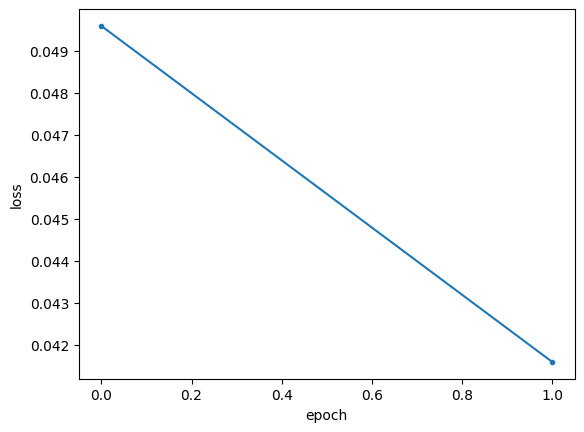

1/1 [==============================] - 0s 418ms/step


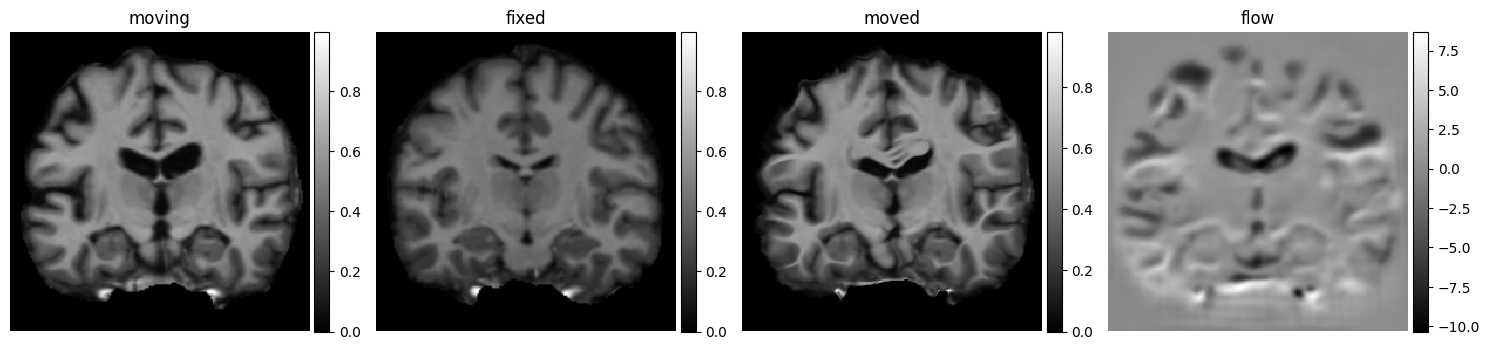

1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 22ms/epoch - 22ms/step


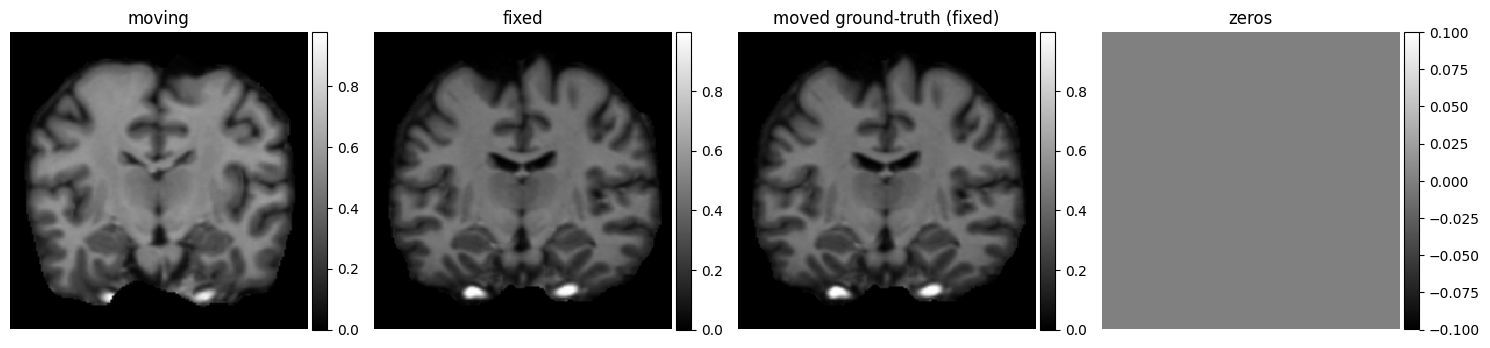

0epoch [00:00, ?epoch/s]

1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 27ms/epoch - 27ms/step


  0%|          | 0.00/100 [00:00<?, ?batch/s]

Epoch 1/2
1/1 - 0s - 30ms/epoch - 30ms/step
1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 75ms/epoch - 75ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 47ms/epoch - 47ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 43ms/epoch - 43ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 44ms/epoch - 44ms/step
1/1 - 0s - 21ms/epoch - 21ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 21ms/epoch - 21ms/step
1/1 - 0s - 45ms/epoch - 45ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 45ms/epoch - 45ms/step
1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 39ms/epoch - 39ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 

  0%|          | 0.00/100 [00:00<?, ?batch/s]

Epoch 2/2
1/1 - 0s - 93ms/epoch - 93ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 33ms/epoch - 33ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 44ms/epoch - 44ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 44ms/epoch - 44ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 43ms/epoch - 43ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 37ms/epoch - 37ms/step
1/1 - 0s - 29ms/epoch - 29ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 33ms/epoch - 33ms/step
1/1 - 0s - 29ms/epoch - 29ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 29ms/epoch - 29ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 

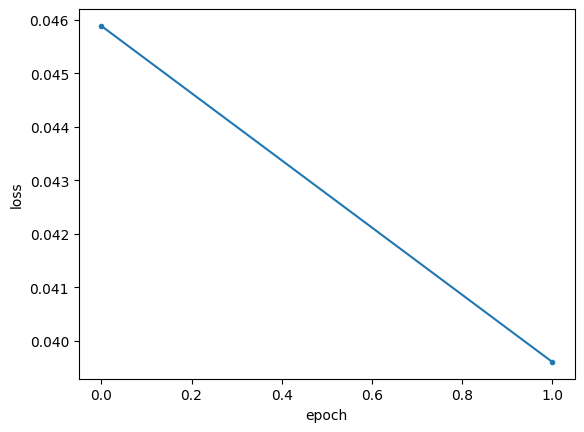

1/1 [==============================] - 0s 337ms/step


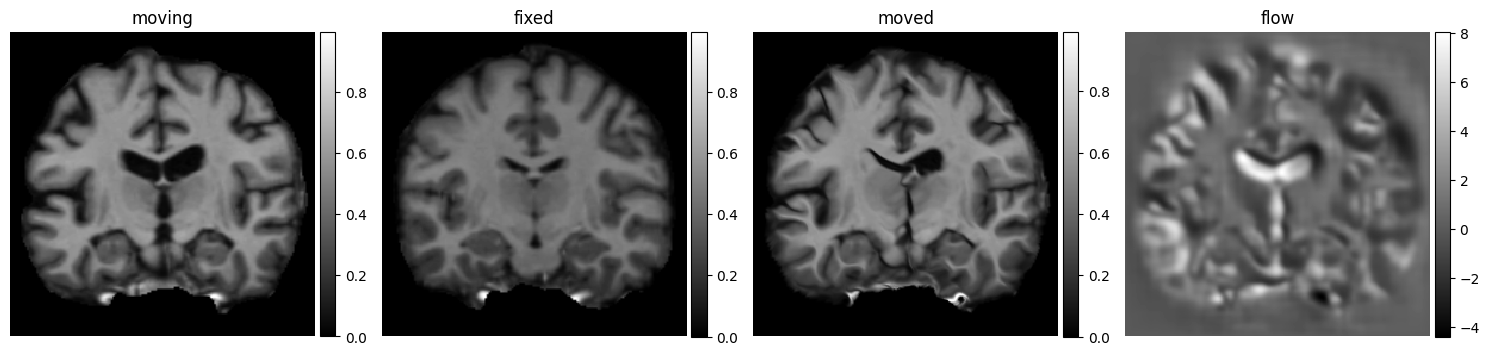

In [27]:
#Few shots training
for k in range(5, 15, 5):
    exec(f'Hybrid_fshot_{k} = VxmTest()')
    exec(f'Hybrid_fshot_{k}.CNNvxm(train_gen=few_generator_{k}, val_generator=val_generator)')
    exec(f'Hybrid_fshot_{k}.train(total_epo = train_no)')
    exec(f'loc = model_loc+name+str({k})+goblin')
    exec(f'Hybrid_fshot_{k}.vxm_model.save_weights(model_loc+name+str({k})+goblin)')
    exec(f'b = Hybrid_fshot_{k}.hist.history[led]')
    exec(f'df = pd.DataFrame(b)')
    exec(f'loc = csv_loc+name_loss+str({k})+goblin_csv')
    exec(f'df.to_csv(loc, index=False, header=False)')
    # for i in range(no_of_rounds-1):
    #     exec(f'Hybrid_fshot_{k}.vxm_model.load_weights(model_loc+name+str({k})+goblin)')
    #     exec(f'Hybrid_fshot_{k}.train(total_epo = train_no)')
    #     exec(f'Hybrid_fshot_{k}.vxm_model.save_weights(model_loc+name+str({k})+goblin)')
    #     exec(f'b = Hybrid_fshot_{k}.hist.history[led]')
    #     exec(f'df = pd.DataFrame(b)')
    #     exec(f'loc = csv_loc+name_loss+str({k})+goblin_csv')
    #     exec(f'df.to_csv(loc, mode = mode_csv, index=False, header=False)')

    exec(f'Hybrid_fshot_{k} = Hybrid_fshot_{k}.RegPred(val_input)[1]')

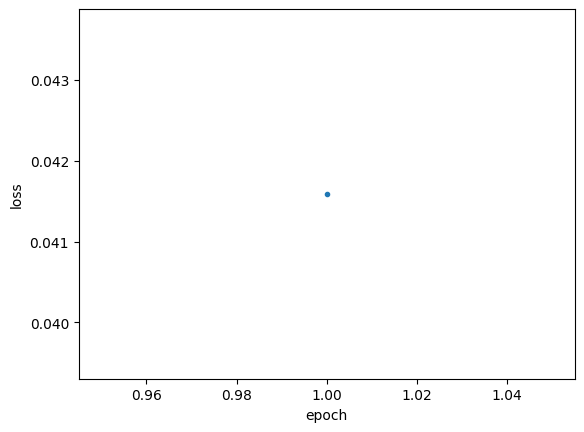

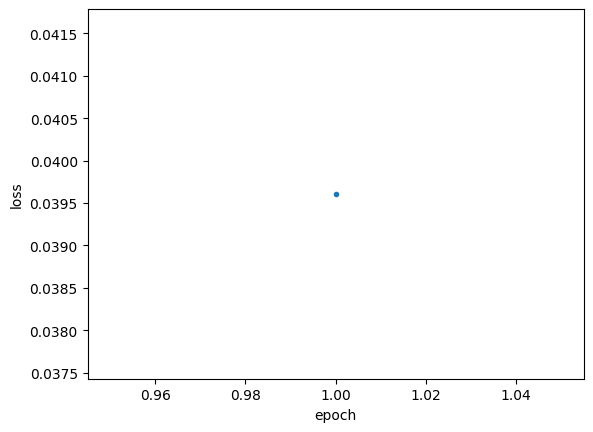

In [28]:
for k in range(5, 15, 5):
    exec(f'loc = csv_loc+name_loss+str({k})+goblin_csv')
    exec(f'plot_csv(loc)')

In [29]:
# goblin = '.h5'
# goblin_csv = '.csv'
# name = 'Hybr_'
# mode_csv = 'a'
# name_loss = 'Hybr_Loss_'

In [30]:
# for k in range(0, 100, 5):
#     exec(f'Hybr_{k} = VxmTest()')
#     exec(f'hybrid_generator_{k} = vxm_data_generator_hybrid(real_train, label_maps_synth, SynthIm.label_to_image, alpha_real=k/100, batch_size=batch_size)')
#     exec(f'Hybr_{k}.CNNvxm(train_gen=hybrid_generator_{k}, val_generator=val_generator)')
#     exec(f'Hybr_{k}.train(total_epo = train_no)')
#     exec(f'Hybr_{k}.vxm_model.save_weights(model_loc+name+str({k})+goblin)')
#     led = 'loss'
#     exec(f'b = Hybr_{k}.hist.history[led]')
#     exec(f'df = pd.DataFrame(b)')
#     exec(f'loc = csv_loc+name_loss+str({k})+goblin_csv')
#     exec(f'df.to_csv(loc, index=False, header=False)')
#     for i in range(no_of_rounds-1):
#         exec(f'Hybr_{k}.vxm_model.load_weights(model_loc+name+str({k})+goblin)')
#         exec(f'Hybr_{k}.train(total_epo = train_no)')
#         exec(f'Hybr_{k}.vxm_model.save_weights(model_loc+name+str({k})+goblin)')
#         led = 'loss'
#         exec(f'b = Hybr_{k}.hist.history[led]')
#         exec(f'df = pd.DataFrame(b)')
#         exec(f'loc = csv_loc+name_loss+str({k})+goblin_csv')
#         exec(f'df.to_csv(loc, mode = mode_csv, index=False, header=False)')
#     exec(f'hybr_{k} = Hybr_{k}.RegPred(val_input)[1]')

In [31]:
# for k in range(0, 100, 5):
#     exec(f'loc = csv_loc+name_loss+str({k})+goblin_csv')
#     exec(f'plot_csv(loc)')

1/1 [==============================] - 0s 336ms/step


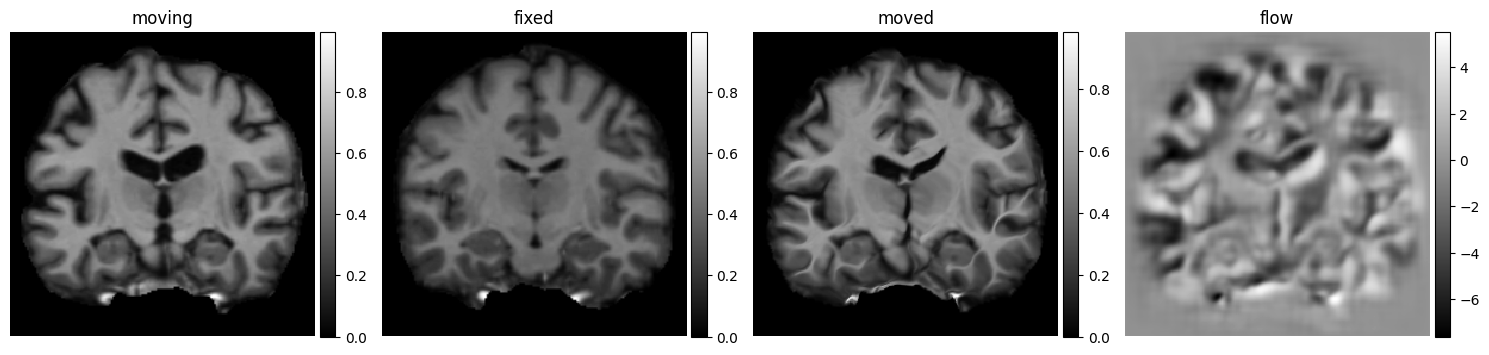

1/1 [==============================] - 0s 374ms/step


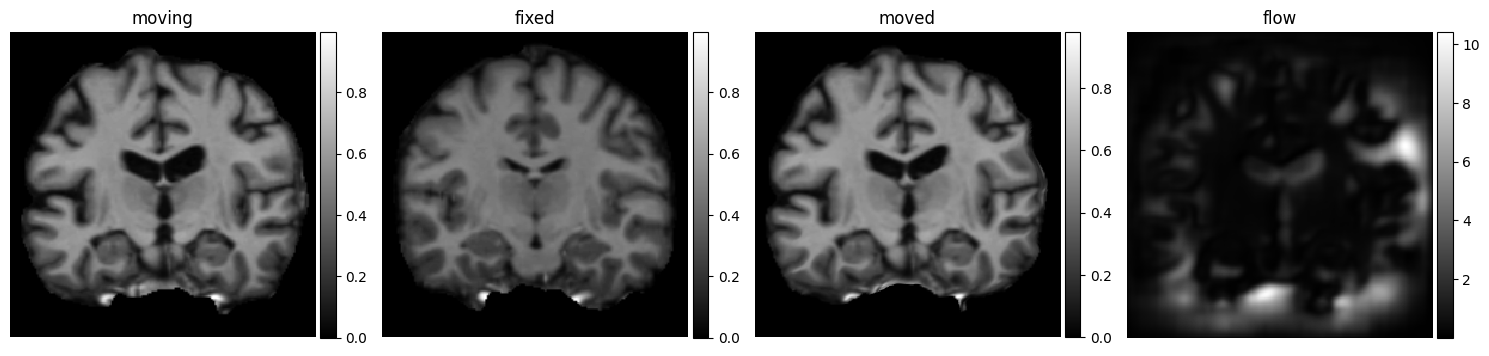

In [32]:
real = Real.RegPred(val_input)[1]
synth = Synth.RegPred(val_input)[1]

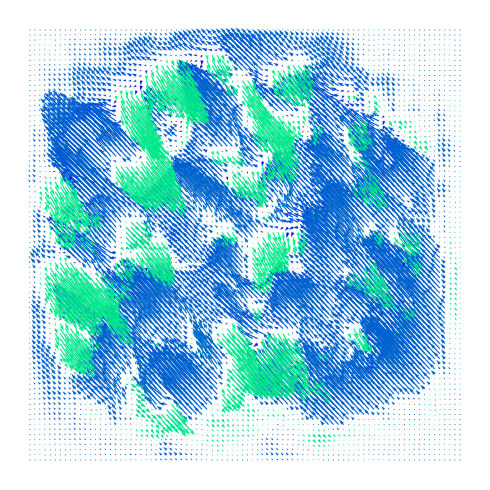

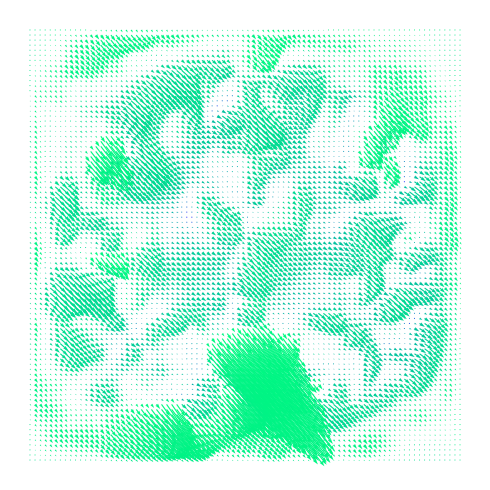

In [33]:
ne.plot.flow([real[1].squeeze()[::3,::3]], width=5);
ne.plot.flow([synth[1].squeeze()[::3,::3]], width=5);

In [34]:
# for k in range(0, 100, 5):
#     exec(f'ne.plot.flow([hybr_{k}[1].squeeze()],titles=k, width=5);')

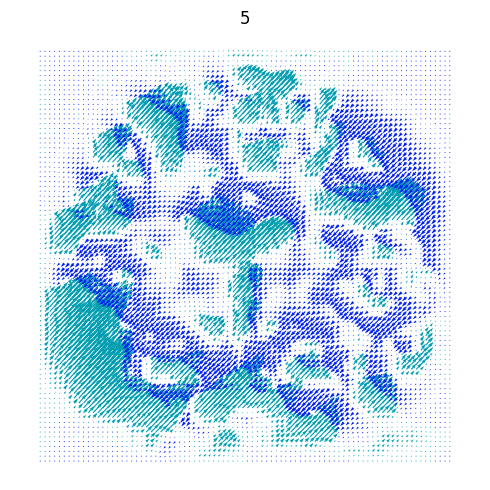

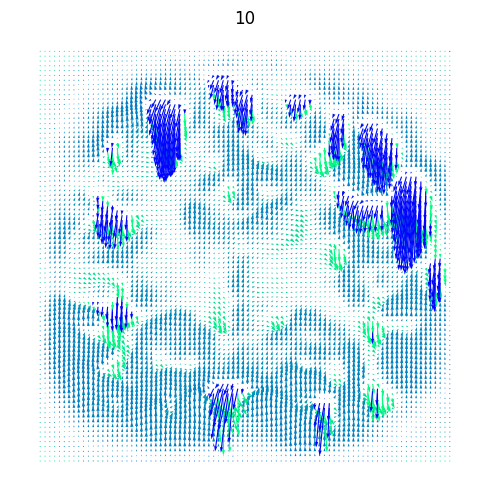

In [35]:
for k in range(5, 15, 5):
    exec(f'ne.plot.flow([fshot_{k}[0].squeeze()[::3, ::3]],titles=k, width=5);')

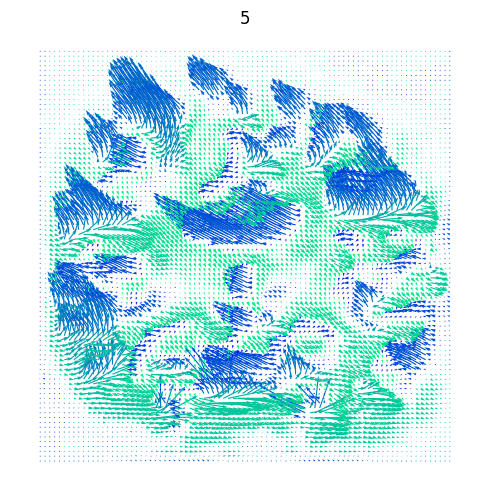

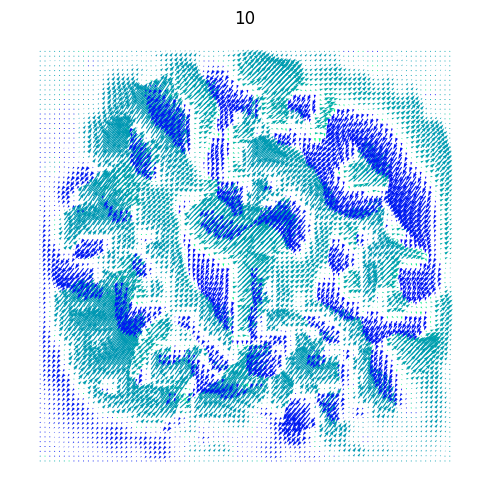

In [36]:
for k in range(5, 15, 5):
    exec(f'ne.plot.flow([Hybrid_fshot_{k}[0].squeeze()[::3, ::3]],titles=k, width=5);')